In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

from recycle_cnn import CNN
from recycle_resnet import ResNet, BasicBlock


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.001
epochs = 10
batch_size=16

In [3]:
trans = transforms.ToTensor()

train_set = torchvision.datasets.ImageFolder('data/train',transform=trans)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [4]:
valid_set = torchvision.datasets.ImageFolder('data/valid',transform=trans)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [5]:
model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device))

In [6]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_batch = len(train_loader)

In [7]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=786432, out_features=128, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [8]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach()
    loss = (running_loss / len(data_loader)).item()
    return loss

In [9]:
def eval_one_epoch(data_loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        return loss, accuracy

In [10]:
train_loss_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
for epoch in range(epochs):
    train_loss = train_one_epoch(train_loader)
    train_loss_hist.append(train_loss)

    valid_loss, valid_acc = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    print(f"Epoch: {epoch}, Train Loss: {train_loss_hist[-1]}, "\
        f"Valid loss: {valid_loss_hist[-1]}, Valid accuracy: {valid_acc_hist[-1]}")

Epoch: 0, Train Loss: 557.7316284179688, Valid loss: 364.5862121582031, Valid accuracy: 40.85365676879883
Epoch: 1, Train Loss: 259.7502136230469, Valid loss: 349.9713439941406, Valid accuracy: 52.1341438293457
Epoch: 2, Train Loss: 202.66200256347656, Valid loss: 185.73341369628906, Valid accuracy: 51.21950912475586
Epoch: 3, Train Loss: 110.93495178222656, Valid loss: 151.6901397705078, Valid accuracy: 54.878047943115234
Epoch: 4, Train Loss: 67.35993194580078, Valid loss: 152.2220916748047, Valid accuracy: 55.182926177978516
Epoch: 5, Train Loss: 40.34437942504883, Valid loss: 249.67710876464844, Valid accuracy: 42.9878044128418
Epoch: 6, Train Loss: 36.3762092590332, Valid loss: 144.09881591796875, Valid accuracy: 53.96341323852539
Epoch: 7, Train Loss: 21.374387741088867, Valid loss: 224.53271484375, Valid accuracy: 45.42682647705078
Epoch: 8, Train Loss: 22.17289161682129, Valid loss: 148.16346740722656, Valid accuracy: 59.146339416503906
Epoch: 9, Train Loss: 18.564605712890625,

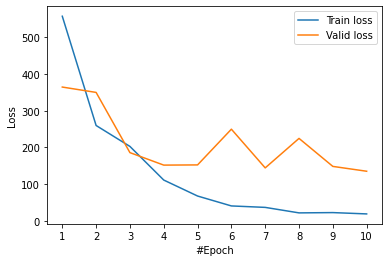

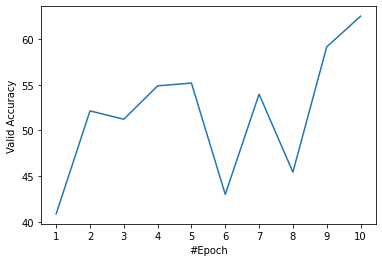

In [11]:
epochs = list(range(1, epochs + 1))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.plot(epochs, valid_acc_hist)
plt.xlabel("#Epoch")
plt.ylabel("Valid Accuracy")
plt.xticks(epochs)
plt.show()


In [12]:
torch.save(model, 'model.pt')